In [14]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import mediapipe as mp
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import warnings

# Thêm đường dẫn dẫn đến thư mục cha
sys.path.append(os.path.abspath(".."))
warnings.filterwarnings("ignore")

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# IMPORTANT_LMS = [
#     "nose",
#     "left_eye_inner",
#     "left_eye",
#     "left_eye_outer",
#     "right_eye_inner",
#     "right_eye",
#     "right_eye_outer",
#     "left_ear",
#     "right_ear",
#     "mouth_left",
#     "mouth_right",
#     "left_shoulder",
#     "right_shoulder",
#     "left_elbow",
#     "right_elbow",
#     "left_wrist",
#     "right_wrist",
#     "left_pinky",
#     "right_pinky",
#     "left_index",
#     "right_index",
#     "left_thumb",
#     "right_thumb",
#     "left_hip",
#     "right_hip",
#     "left_knee",
#     "right_knee",
#     "left_ankle",
#     "right_ankle",
#     "left_heel",
#     "right_heel",
#     "left_foot_index",
#     "right_foot_index",
# ]


IMPORTANT_LMS = [
    "nose",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_pinky",
    "right_pinky",
    "left_index",
    "right_index",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_foot_index",
    "right_foot_index",
]

# Scale support

In [16]:
def square_for_image(path: str):
    # Đọc hình ảnh gốc
    image_path = path  # Thay bằng đường dẫn đến hình ảnh của bạn
    original_image = Image.open(image_path)

    # Kích thước ảnh gốc và ảnh mới
    original_size = original_image.size

    # Kích thước ảnh mới sẽ là kích thước lớn nhất của ảnh gốc
    max_width = max(original_size)

    new_size = (max_width, max_width)

    # Tạo một ảnh mới với nền đen
    new_image = Image.new("RGB", new_size, (0, 0, 0))

    # Dán ảnh gốc vào ảnh mới với khoảng trống màu đen
    new_image.paste(original_image, 
                    ((max_width - original_size[0]) // 2, (max_width - original_size[1]) // 2))

    # convert new_image to cv2 format
    new_image_cv2 = cv2.cvtColor(np.array(new_image), cv2.COLOR_RGB2BGR)

    return new_image_cv2, new_size

# Rotation support

In [17]:
def calculate_phase_difference(OA: tuple, OB: tuple) -> float:
    """
    Calculate the phase difference (in degrees) of vector OB relative to vector OA.
    :param OA: A tuple representing the first vector (OA).
    :param OB: A tuple representing the second vector (OB).
    :return: Phase difference in degrees from 0 to 360.
    """
    # Calculate the dot product and magnitudes
    dot_product = OA[0] * OB[0] + OA[1] * OB[1]
    norm_OA = np.sqrt(OA[0] ** 2 + OA[1] ** 2)
    norm_OB = np.sqrt(OB[0] ** 2 + OB[1] ** 2)

    # Calculate the cosine of the angle
    cos_theta = dot_product / (norm_OA * norm_OB)
    
    # Ensure the value is within the valid range for arccos due to floating-point errors
    cos_theta = np.clip(cos_theta, -1, 1)
    
    # Calculate the angle in radians
    theta = np.arccos(cos_theta)
    
    # Calculate the cross product (only the z-component for 2D vectors)
    cross_product = OA[0] * OB[1] - OA[1] * OB[0]
    
    # Adjust the angle based on the direction
    if cross_product < 0:
        theta = 2 * np.pi - theta

    # Convert the angle to degrees
    theta_degrees = np.degrees(theta)

    return theta_degrees

In [18]:
def rotate_point(point: tuple, center: tuple, angle: float, origin_size = (612, 408)) -> tuple:
    x, y = point
    cx, cy = center

    x_new = (x - cx) * np.cos(np.radians(angle)) * origin_size[0] - (y - cy) * np.sin(np.radians(angle)) * origin_size[1] + cx * origin_size[0]
    y_new = (x - cx) * np.sin(np.radians(angle)) * origin_size[0] + (y - cy) * np.cos(np.radians(angle)) * origin_size[1] + cy * origin_size[1]

    return x_new / origin_size[0], y_new / origin_size[1]

In [19]:
def rotate_keypoints(keypoints, image_path: str, origin_size = (612, 408)) -> np.array:
    left_shoulder = keypoints.landmark[11]
    right_shoulder = keypoints.landmark[12]
    left_hip = keypoints.landmark[23]
    right_hip = keypoints.landmark[24]

    center_shoulder = (left_shoulder.x + right_shoulder.x) / 2, (left_shoulder.y + right_shoulder.y) / 2
    center_hip = (left_hip.x + right_hip.x) / 2, (left_hip.y + right_hip.y) / 2

    center = (center_shoulder[0] + center_hip[0]) / 2, (center_shoulder[1] + center_hip[1]) / 2

    O_center_shoulder = (center_shoulder[0] - center[0], center_shoulder[1] - center[1])
    Oy = (0, -1)

    theta = calculate_phase_difference(O_center_shoulder, Oy)

    # rotate each key point
    for point in keypoints.landmark:
        point_rotated = rotate_point((point.x, point.y), center, theta, origin_size)
        point.x = point_rotated[0]
        point.y = point_rotated[1]

    return keypoints

In [20]:
def find_center_of_mass(df_key_points):
    left_hip = (df_key_points["left_hip_x"], df_key_points["left_hip_y"])
    right_hip = (df_key_points["right_hip_x"], df_key_points["right_hip_y"])
    
    # Find the center of the hips
    center_hip = ((left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2)

    # Get the sholder coordinates
    left_shoulder = (df_key_points["left_shoulder_x"], df_key_points["left_shoulder_y"])
    right_shoulder = (df_key_points["right_shoulder_x"], df_key_points["right_shoulder_y"])

    center_shoulder = ((left_shoulder[0] + right_shoulder[0]) / 2, (left_shoulder[1] + right_shoulder[1]) / 2)

    return (center_hip[0] + center_shoulder[0]) / 2, (center_hip[1] + center_shoulder[1]) / 2

def process_image(image_path):
    """Load and pre-process the image."""
    image, new_size = square_for_image(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), new_size

def calculate_scale_value(df_key_points):
    """Calculate the scale value based on nose and hip points."""
    left_hip = (df_key_points["left_hip_x"], df_key_points["left_hip_y"])
    right_hip = (df_key_points["right_hip_x"], df_key_points["right_hip_y"])
    
    # Find the center of the hips
    center_hip = ((left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2)

    # Get the sholder coordinates
    left_shoulder = (df_key_points["left_shoulder_x"], df_key_points["left_shoulder_y"])
    right_shoulder = (df_key_points["right_shoulder_x"], df_key_points["right_shoulder_y"])

    center_shoulder = ((left_shoulder[0] + right_shoulder[0]) / 2, (left_shoulder[1] + right_shoulder[1]) / 2)

    # Calculate the distance between nose and center of the hips
    distance = np.sqrt((center_hip[0] - center_shoulder[0])**2 + (center_hip[1] - center_shoulder[1])**2)

    # Scale value based on distance
    return 0.5 / distance

def scale_keypoints(df_key_points, scale_value):
    """Scale all key points based on the calculated scale value."""
    for landmark in IMPORTANT_LMS:
        df_key_points[f"{landmark}_x"] *= scale_value
        df_key_points[f"{landmark}_y"] *= scale_value
    return df_key_points

def save_keypoints_to_csv(df_key_points, output_file):
    """Save keypoints to CSV file."""
    with open(output_file, "a") as f:
        df_key_points.to_csv(f, header=f.tell() == 0, index=False)

# Extract data

In [21]:
def extract_key_points_from_image(image_path: str, label: str, output_file: str, is_draw_landmarks=False):
    # Initialize MediaPipe Pose once
    mp_pose = mp.solutions.pose
    with mp_pose.Pose(static_image_mode=True, model_complexity=1, smooth_landmarks=True) as pose:
        
        image_rgb, new_size = process_image(image_path)
        results = pose.process(image_rgb)

        if not results.pose_landmarks:
            print(f"Cannot detect pose in image {image_path}")
            return

        # Rotate the keypoints
        results.pose_landmarks = rotate_keypoints(results.pose_landmarks, image_path, new_size)

        # Prepare data for CSV
        columns_name = ["label"] + [f"{landmark}_{axis}" for landmark in IMPORTANT_LMS for axis in ['x', 'y', 'z']]
        columns_value = [label]

        for id, landmark in enumerate(results.pose_landmarks.landmark):
            if mp_pose.PoseLandmark(id).name.lower() in IMPORTANT_LMS:
                # Adjust keypoint coordinates
                columns_value.extend([landmark.x, landmark.y, landmark.z])

        df_key_points = pd.DataFrame([columns_value], columns=columns_name)

        center = find_center_of_mass(df_key_points)
        shifting = (0 - center[0], 0 - center[1])

        for landmark in IMPORTANT_LMS:
            df_key_points[f"{landmark}_x"] += shifting[0]
            df_key_points[f"{landmark}_y"] += shifting[1]

        # Calculate the scale value based on the distance between nose and hip
        scale_value = calculate_scale_value(df_key_points)

        # Scale keypoints
        df_key_points = scale_keypoints(df_key_points, scale_value)

        # Save keypoints to CSV
        save_keypoints_to_csv(df_key_points, output_file)

In [22]:
def auto_label_from_folder(folder_path: str, output_file: str, label: str = None):
    """
    Tự động gán nhãn cho các ảnh trong thư mục
    """ 
    # Traverse the folder and process each file
    for root, _, files in os.walk(folder_path):
        print(f"Processing folder {root}")
        for file in files:
            file_path = os.path.join(root, file)
            label = label if label else os.path.basename(root)
            extract_key_points_from_image(file_path, label, output_file)

In [23]:
output_csv = "../../data/data_testing_cleaned.csv"

In [24]:
auto_label_from_folder("../../data_images/testing/1_lie_on", output_csv)

auto_label_from_folder("../../data_images/testing/2_side", output_csv)

auto_label_from_folder("../../data_images/testing/3_procumbent", output_csv)

Processing folder ../../data_images/testing/1_lie_on
Cannot detect pose in image ../../data_images/testing/1_lie_on\25.jpg
Processing folder ../../data_images/testing/2_side
Processing folder ../../data_images/testing/3_procumbent


In [25]:
df = pd.read_csv(output_csv)

<Axes: xlabel='label', ylabel='count'>

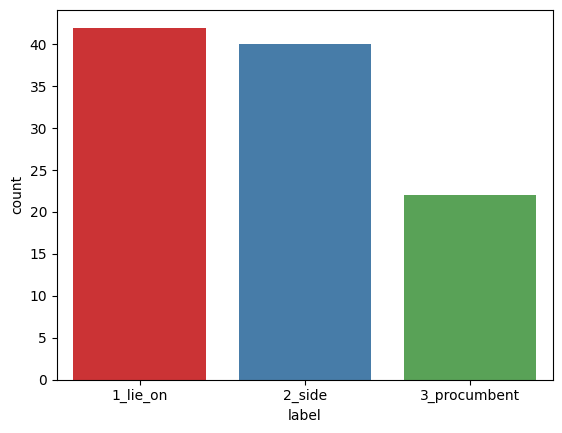

In [26]:
sns.countplot(data=df, x="label", palette="Set1")